In [2]:
import sys, os
import numpy as np
import math
from sklearn.feature_selection import mutual_info_classif


os.chdir('/Users/songtengyu/Documents/2023Fall/Information theory/fr-train/')
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import math
import matplotlib.pyplot as plt
from argparse import Namespace
from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns

In [82]:
X = np.load('./X_synthetic.npy') # Input features
y = np.load('./y_synthetic.npy') # Labels
s1 = np.load('./s1_synthetic.npy') # Sensitive features

In [83]:
data = np.concatenate((X, y.reshape(-1,1), s1.reshape(-1,1)), axis=1)
data = pd.DataFrame(data)
data.columns = ['x1', 'x2', 'y', 's1']

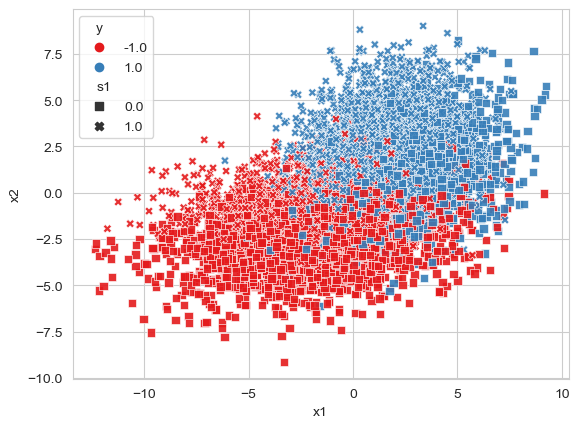

In [84]:
import seaborn as sns

data_sample = data.sample(frac=1).reset_index(drop=True)
sns.set_style("whitegrid")
markers = {0: "s", 1: "X"}
sns.scatterplot(x="x1", y="x2", hue="y", style='s1',markers=markers,\
    data=data_sample, palette="Set1", alpha=0.9)
plt.show()

In [85]:
from scipy.stats import multivariate_normal

sigma = np.array([[10, 1], [1, 3]])
mu = np.array([-2, -2])

def multi_gaussian_pdf(x, mu, sigma):
    return multivariate_normal.pdf(x, mean=mu, cov=sigma)

print(multi_gaussian_pdf(np.array([0,0]), mu, sigma))

0.013840645758115127


In [88]:
# (x1, x2)|y = 0 ∼ N ([−2; −2], [10, 1; 1, 3])
# (x1 , x2 )|y = 1 ∼ N ([2; 2], [5, 1; 1, 5])

# p(z = 1) = p((x′1, x′2)|y = 1)/[p((x′1, x′2)|y = 0) + p((x′1, x′2)|y = 1)] 
# (x′1, x′2) = (x1 cos(π/4) − x2 sin(π/4), x1 sin(π/4) + x2 cos(π/4))

cov_y_0 = np.array([[10, 1], [1, 3]])
cov_y_1 = np.array([[5, 1], [1, 5]])
mu_y_0 = np.array([-2, -2])
mu_y_1 = np.array([2, 2])

N_test = 4000
X_test = np.zeros((N_test, 2))
y_test = np.zeros((N_test, 1))
s1_test = np.zeros((N_test, 1))

for i in range(N_test):
    np.random.seed(i)
    if np.random.rand() < 0.5:
        X_test[i, :] = np.random.multivariate_normal([-2, -2], [[10, 1], [1, 3]])
        y_test[i] = -1
    else:
        X_test[i, :] = np.random.multivariate_normal([2, 2], [[5, 1], [1, 5]])
        y_test[i] = 1
    x_prime_1 = X_test[i, 0] * math.cos(math.pi/4) + X_test[i, 1] * math.sin(math.pi/4)
    x_prime_2 = - X_test[i, 0] * math.sin(math.pi/4) + X_test[i, 1] * math.cos(math.pi/4)
    p_z_1 = multi_gaussian_pdf([x_prime_1, x_prime_2], mu_y_1, cov_y_1) / \
        (multi_gaussian_pdf([x_prime_1, x_prime_2], mu_y_0, cov_y_0) + multi_gaussian_pdf([x_prime_1, x_prime_2], mu_y_1, cov_y_1))
    if np.random.rand() < p_z_1:
        s1_test[i] = 1
    else:
        s1_test[i] = 0

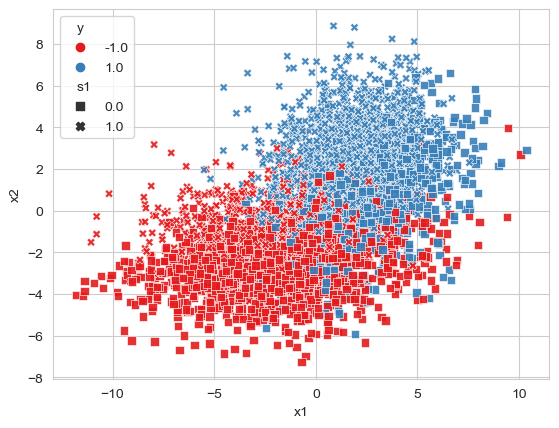

In [89]:
data_generated = np.concatenate((X_test, y_test, s1_test), axis=1)
data_generated = pd.DataFrame(data_generated)
data_generated.columns = ['x1', 'x2', 'y', 's1']

sns.set_style("whitegrid")
markers = {0: "s", 1: "X"}
sns.scatterplot(x="x1", y="x2", hue="y", style='s1',markers=markers,\
    data=data_generated, palette="Set1", alpha=0.9)
plt.show()

In [110]:
def data_gen(ypos_p, zpos_coef, N_test = 7000):
    cov_y_0 = np.array([[10, 1], [1, 3]])
    cov_y_1 = np.array([[5, 1], [1, 5]])
    mu_y_0 = np.array([-2, -2])
    mu_y_1 = np.array([2, 2])

    X_test = np.zeros((N_test, 2))
    y_test = np.zeros((N_test))
    s1_test = np.zeros((N_test))

    for i in range(N_test):
        if np.random.rand() < 1 - ypos_p:
            X_test[i, :] = np.random.multivariate_normal([-2, -2], [[10, 1], [1, 3]])
            y_test[i] = -1
        else:
            X_test[i, :] = np.random.multivariate_normal([2, 2], [[5, 1], [1, 5]])
            y_test[i] = 1
        x_prime_1 = X_test[i, 0] * math.cos(math.pi/4) + X_test[i, 1] * math.sin(math.pi/4)
        x_prime_2 = - X_test[i, 0] * math.sin(math.pi/4) + X_test[i, 1] * math.cos(math.pi/4)
        p_z_1 = multi_gaussian_pdf([x_prime_1, x_prime_2], mu_y_1, cov_y_1) / \
                (multi_gaussian_pdf([x_prime_1, x_prime_2], mu_y_0, cov_y_0) + \
                multi_gaussian_pdf([x_prime_1, x_prime_2], mu_y_1, cov_y_1))
        if np.random.rand() < p_z_1 * zpos_coef:
            s1_test[i] = 1
        else:
            s1_test[i] = 0
    return X_test, y_test, s1_test

In [144]:
def plot_datagen(X, y, s1, text = ''):
    data_generated = np.concatenate((X, y.reshape(-1,1), s1.reshape(-1,1)), axis=1)
    data_generated = pd.DataFrame(data_generated)
    data_generated.columns = ['x1', 'x2', 'y', 's1']

    sns.set_style("white")
    markers = {0: "o", 1: "X"}
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    sns.scatterplot(x="x1", y="x2", hue="y", style='s1',markers=markers,\
        data=data_generated, palette="Set1", alpha=0.9)
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    plt.text(xlim[0] + 0.01 * (xlim[1] - xlim[0]), ylim[1] +0.03 * (ylim[1] - ylim[0]), text, fontsize=11)
    plt.legend(loc='upper left', prop={'size': 10})
    plt.show()

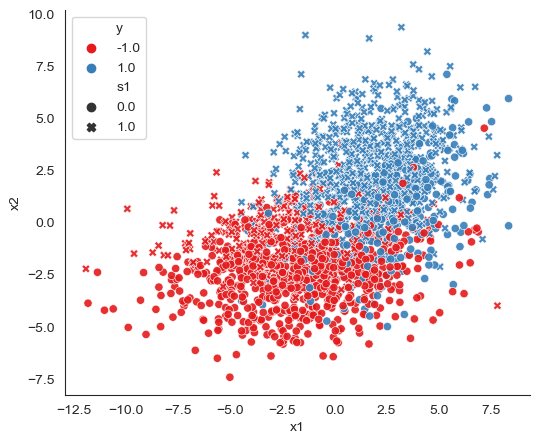

In [149]:
X_test, y_test, s1_test = data_gen(0.5, 1, N_test = 2000)
plot_datagen(X_test, y_test, s1_test, text = '')

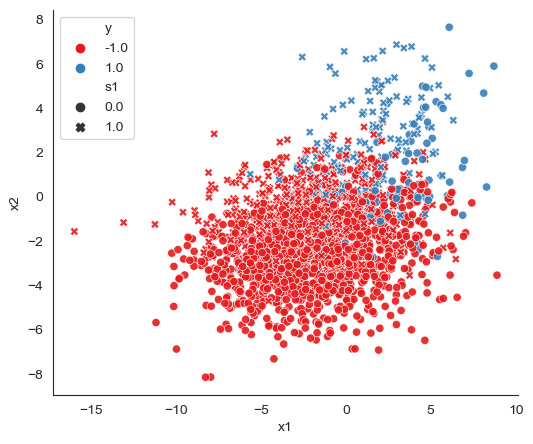

In [150]:
X_test, y_test, s1_test = data_gen(0.1, 1, 2000)
plot_datagen(X_test, y_test, s1_test, text = '')

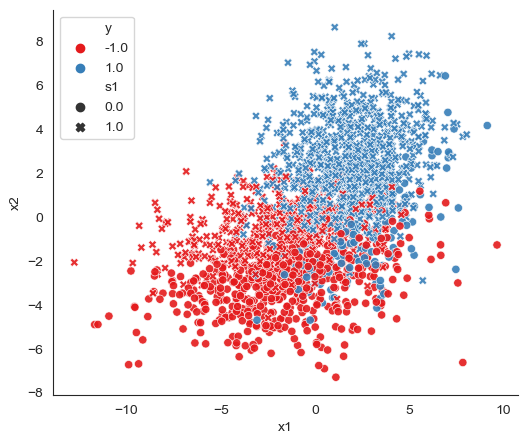

In [151]:
X_test, y_test, s1_test = data_gen(0.5, 2, 2000)
plot_datagen(X_test, y_test, s1_test, text = '')

Text(-0.22, 0.05, 'learning window')

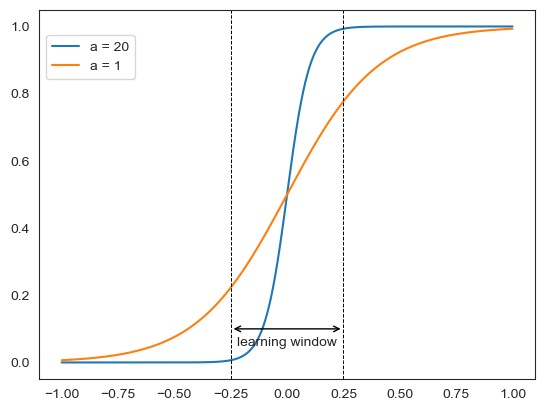

In [53]:
x_lst = np.linspace(-1, 1, 1000)

def sigmoid(x, a):
    x = x * a
    return 1 / (1 + np.exp(-x))

y_lst = sigmoid(x_lst, 20)
y_lst2 = sigmoid(x_lst, 5)

sns.set_style("white")
plt.plot(x_lst, y_lst, label = 'a = 20')
plt.plot(x_lst, y_lst2, label = 'a = 1')
plt.legend(loc='upper left', prop={'size': 10}, bbox_to_anchor=(0, 0.95))
# plt.axhline(y=0, color='k', linestyle='--', alpha = 1, linewidth = 0.7)
# plt.axhline(y=1, color='k', linestyle='--', alpha = 1, linewidth = 0.7)

# plot the learning window where the derivative is larger than 0.1 of the maximum
plt.axvline(x=-0.25, color='k', linestyle='--', alpha = 1, linewidth = 0.7)
plt.axvline(x=0.25, color='k', linestyle='--', alpha = 1, linewidth = 0.7)
# add a two way black arrow between the two vertical lines
plt.annotate('', xy=(-0.25, 0.1), xytext=(0.25, 0.1), arrowprops=dict(arrowstyle='<->', color='black'))
plt.text(-0.22, 0.05, 'learning window', fontsize=10)

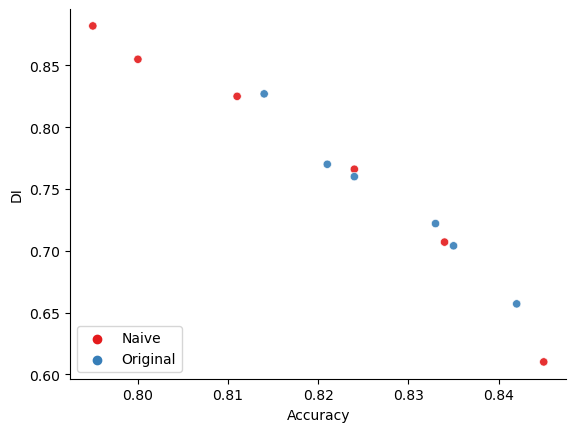

In [10]:
res = pd.read_csv('./res/poi_comp.csv')
sns.scatterplot(x="Accuracy", y="DI", hue="Type", data=res, palette="Set1", alpha=0.9)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='lower left', prop={'size': 10})

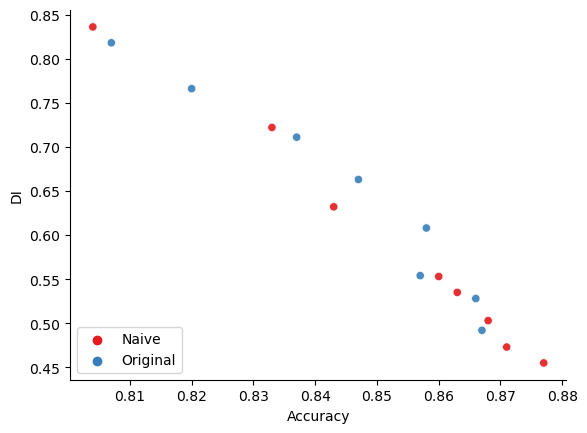

In [11]:
res = pd.read_csv('./res/clean_comp.csv')
sns.scatterplot(x="Accuracy", y="DI", hue="Type", data=res, palette="Set1", alpha=0.9)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='lower left', prop={'size': 10})

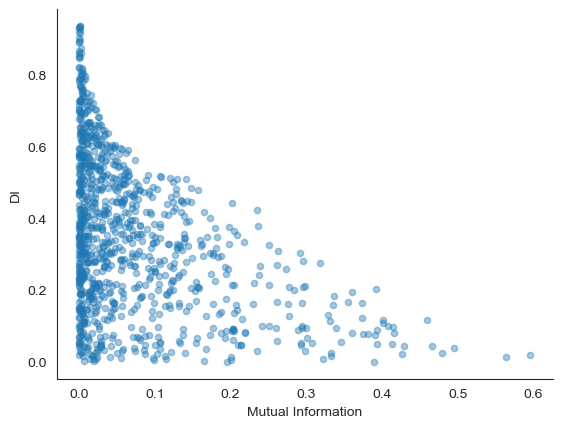

In [64]:
# di and mutual information

mi_lst = []
di_lst = []

for i in range(1000):
    np.random.seed(i + 42)
    p_z1 = np.random.rand()
    p_z0 = 1 - p_z1
    P_y1_given_z1 = np.random.rand()
    P_y0_given_z1 = 1 - P_y1_given_z1
    P_y1_given_z0 = np.random.rand()
    P_y0_given_z0 = 1 - P_y1_given_z0
    p_z1_y1 = p_z1 * P_y1_given_z1
    p_z0_y1 = p_z0 * P_y1_given_z0
    p_z1_y0 = p_z1 * P_y0_given_z1
    p_z0_y0 = p_z0 * P_y0_given_z0
    p_y1 = p_z1_y1 + p_z0_y1
    p_y0 = p_z1_y0 + p_z0_y0
    h_Y = - p_y1 * np.log(p_y1) - p_y0 * np.log(p_y0)
    h_Y_given_Z = - p_z1 * (P_y1_given_z1 * np.log(P_y1_given_z1) + P_y0_given_z1 * np.log(P_y0_given_z1)) \
        - p_z0 * (P_y1_given_z0 * np.log(P_y1_given_z0) + P_y0_given_z0 * np.log(P_y0_given_z0))  
    mi = h_Y - h_Y_given_Z
    di = min(P_y1_given_z1, P_y0_given_z1) / max(P_y1_given_z0, P_y0_given_z0)
    mi_lst.append(mi)
    di_lst.append(di)
    
sns.set_style("white")
plt.scatter(mi_lst, di_lst, alpha = 0.4, s = 20)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Mutual Information')
plt.ylabel('DI')
plt.show()

In [ ]:
test_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
test_lst[:3]